In [1]:
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50
import imgaug as ia
import imgaug.augmenters as iaa
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from Reader import read_dataset

tf.get_logger().setLevel(3)
import cv2
import os, glob
import pandas as pd
import Helper

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42

In [3]:
def create_model(channel_size=3):
    input_shape = []
    if channel_size == 3:  #RGB or XYZ channels
        input_shape = [IMAGE_WIDTH, IMAGE_HEIGHT, channel_size]
    elif channel_size == 1:  #Grayscaled images
        input_shape = [IMAGE_WIDTH, IMAGE_HEIGHT, 1]
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(256, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.4),
        Dense(256, activation="relu"),
        Dense(4, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  metrics=['accuracy'])

    return model

In [4]:
#Display the model layers
model_display = create_model()
model_display.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 128)    512       
 hNormalization)                                                 
                                                        

In [5]:
def strafied_kfold(model, X_train, y_train, X_test, y_test):
    # Define a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    acc = []
    val_acc = []
    test_acc = []
    loss = []
    val_loss = []
    test_loss = []
    # Iterate over the K folds
    for train_index, test_index in skf.split(X_train, np.argmax(y_train, axis=1)):
        # Split the data into K folds
        X_fold_train, X_fold_val = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[test_index]
        # Train and evaluate the model on the fold
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)
        history = model.fit(X_fold_train, y_fold_train,
                            validation_data=(X_fold_val, y_fold_val),
                            epochs=6,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(X_fold_train) / BATCH_SIZE)
        score = model.evaluate(X_test, y_test, verbose=2)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        acc = np.concatenate((acc, history.history['accuracy']), axis=None)
        val_acc = np.concatenate((val_acc, history.history['val_accuracy']), axis=None)
        loss = np.concatenate((loss, history.history['loss']), axis=None)
        val_loss = np.concatenate((val_loss, history.history['val_loss']), axis=None)
        test_acc.append(score[1])
        test_loss.append(score[0])
    return model, acc, val_acc, loss, val_loss, test_acc, test_loss

In [6]:
techniques = ["Default", "Color Normalization", "Canny Edge", "Gray Scale", "XYZ", "HSV", "Binarization"]
single_channels = ["Canny Edge", "Gray Scale", "Binarization"]

Epoch 1/6
36/36 [==============================] - 113s 3s/step - loss: 3.8468 - accuracy: 0.4280 - val_loss: 2.1384 - val_accuracy: 0.4931
Epoch 2/6
36/36 [==============================] - 109s 3s/step - loss: 1.1014 - accuracy: 0.5556 - val_loss: 3.9213 - val_accuracy: 0.5000
Epoch 3/6
36/36 [==============================] - 107s 3s/step - loss: 0.9952 - accuracy: 0.5885 - val_loss: 5.5170 - val_accuracy: 0.5000
Epoch 4/6
36/36 [==============================] - 108s 3s/step - loss: 0.9565 - accuracy: 0.5894 - val_loss: 7.0052 - val_accuracy: 0.5000
Epoch 5/6
36/36 [==============================] - 110s 3s/step - loss: 0.8723 - accuracy: 0.6259 - val_loss: 7.7286 - val_accuracy: 0.5000
Epoch 6/6
36/36 [==============================] - 107s 3s/step - loss: 0.7993 - accuracy: 0.6684 - val_loss: 8.2015 - val_accuracy: 0.5104
12/12 - 8s - loss: 8.1040 - accuracy: 0.5096 - 8s/epoch - 698ms/step
Test loss: 8.103959083557129
Test accuracy: 0.5096418857574463
Epoch 1/6
36/36 [===========

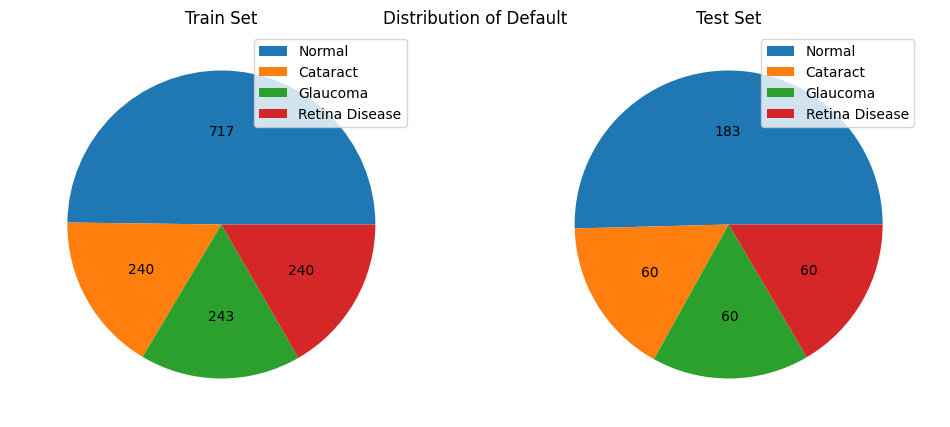

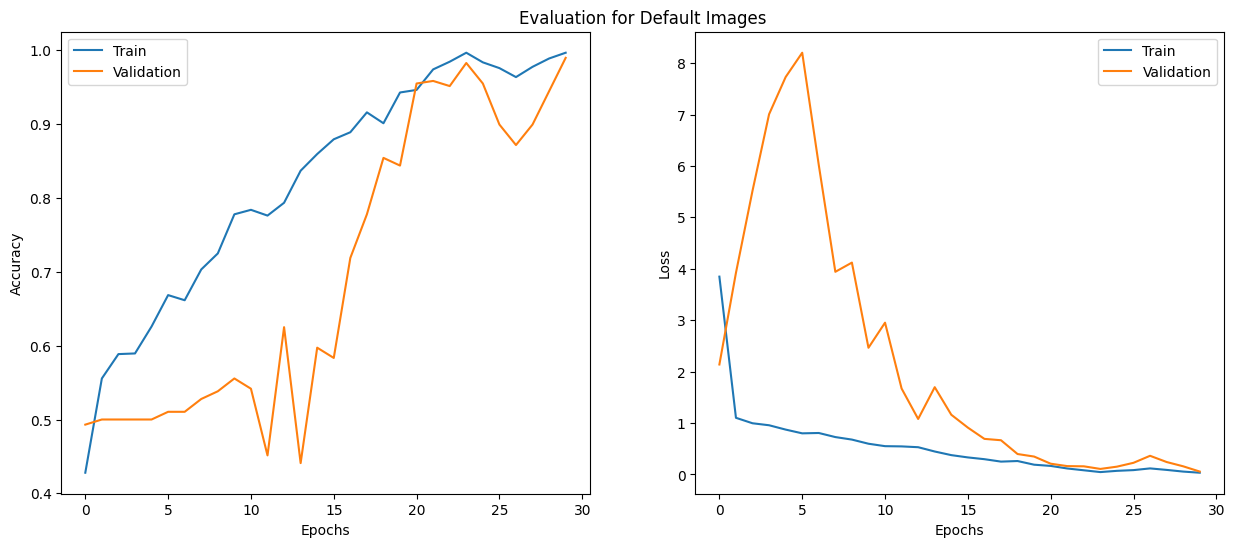

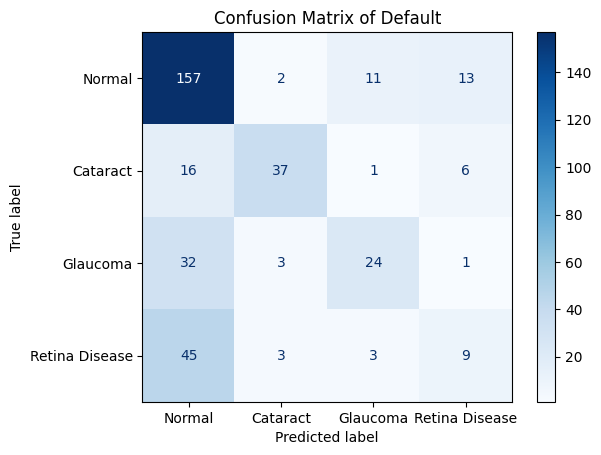

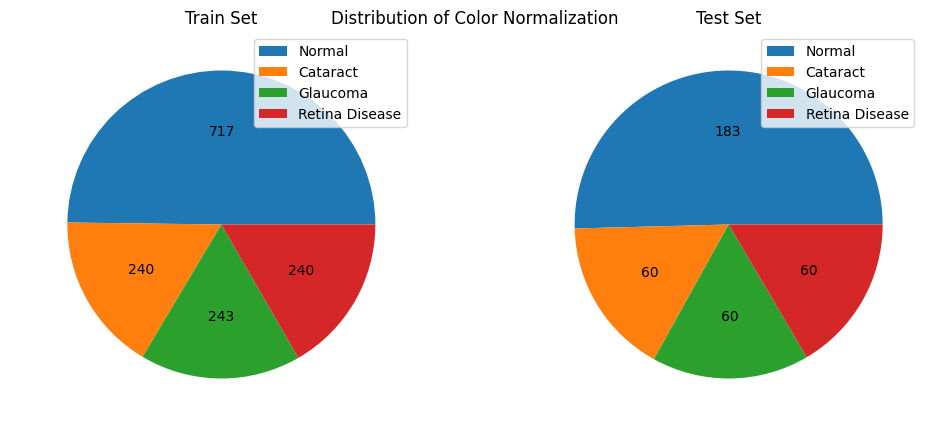

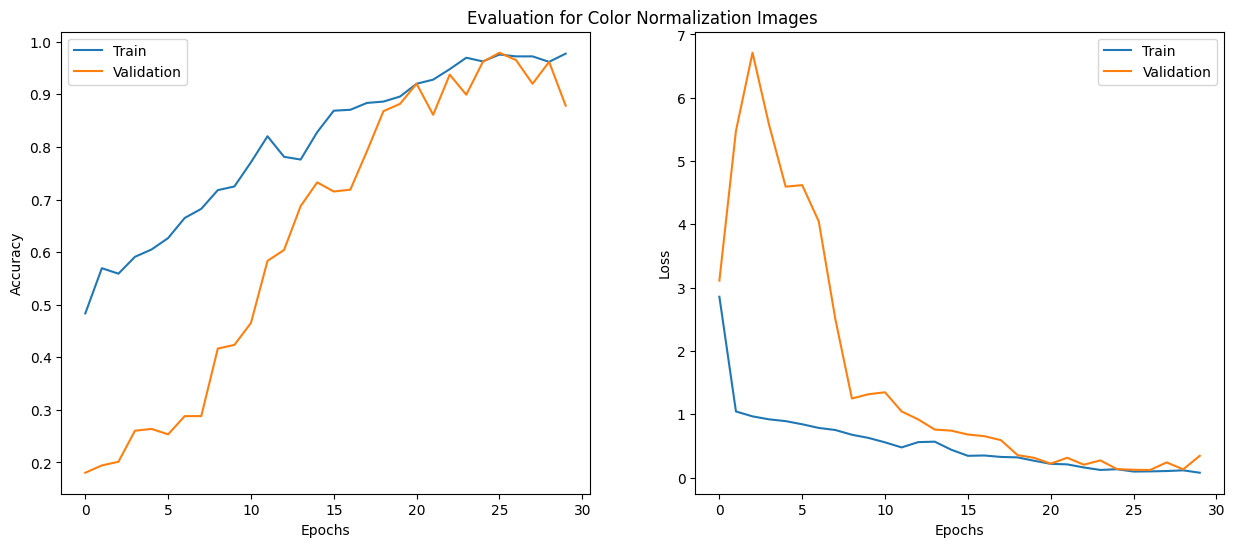

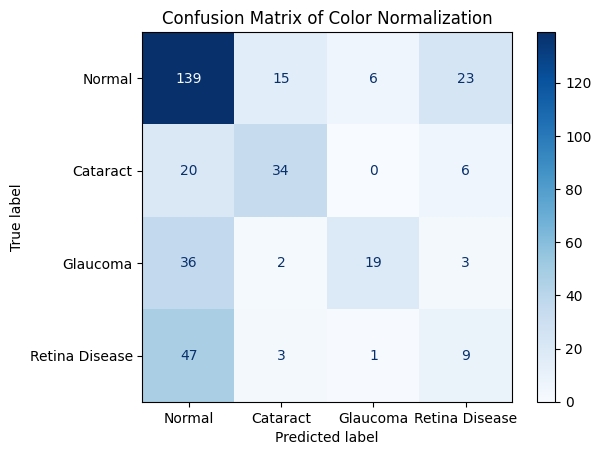

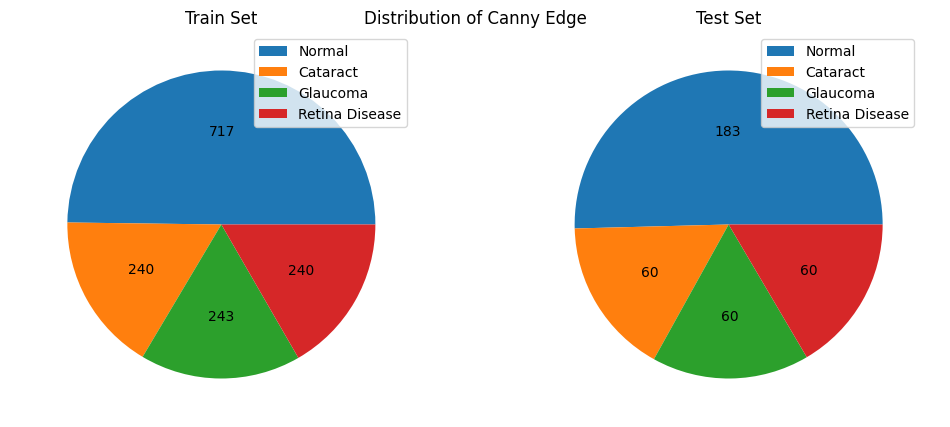

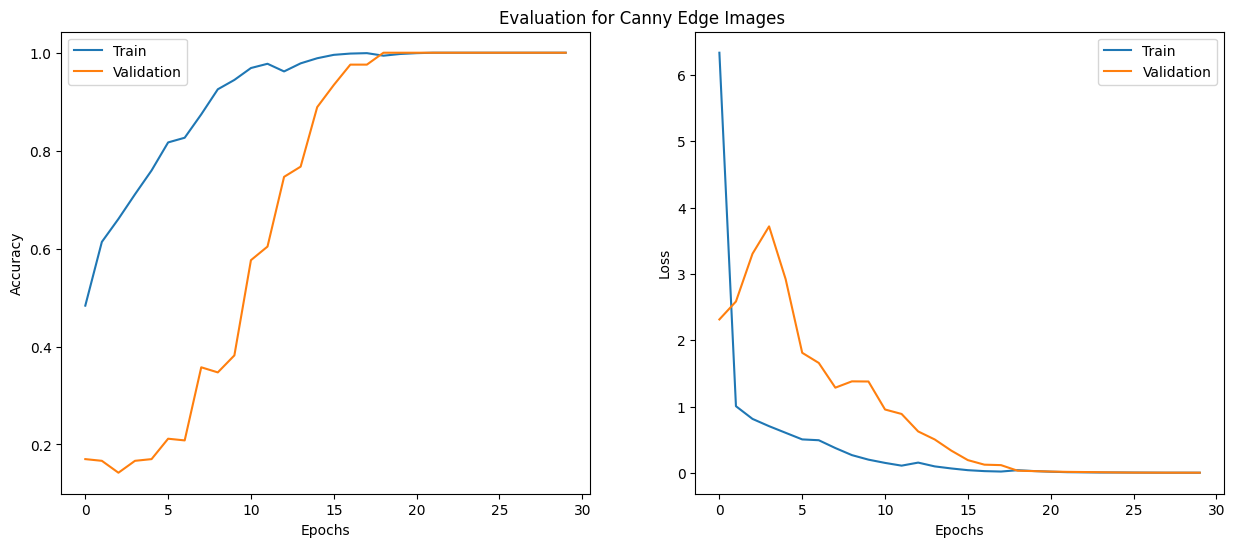

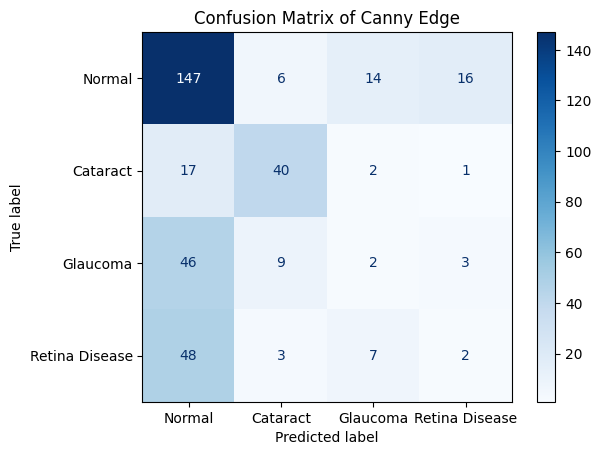

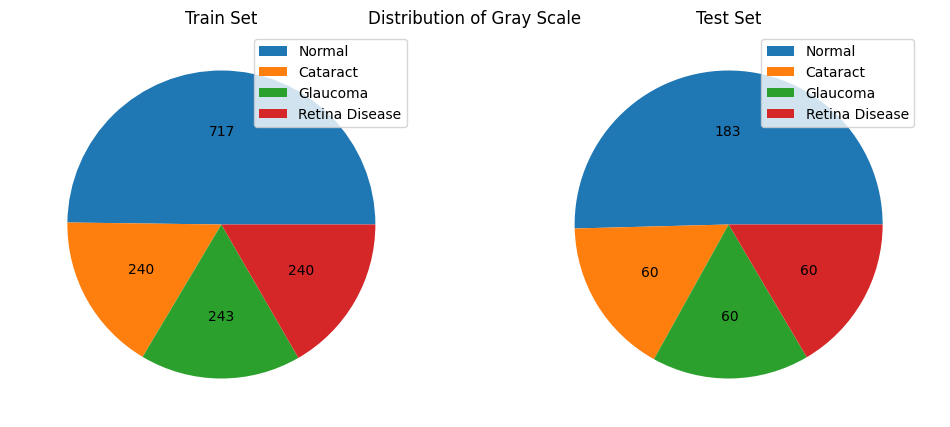

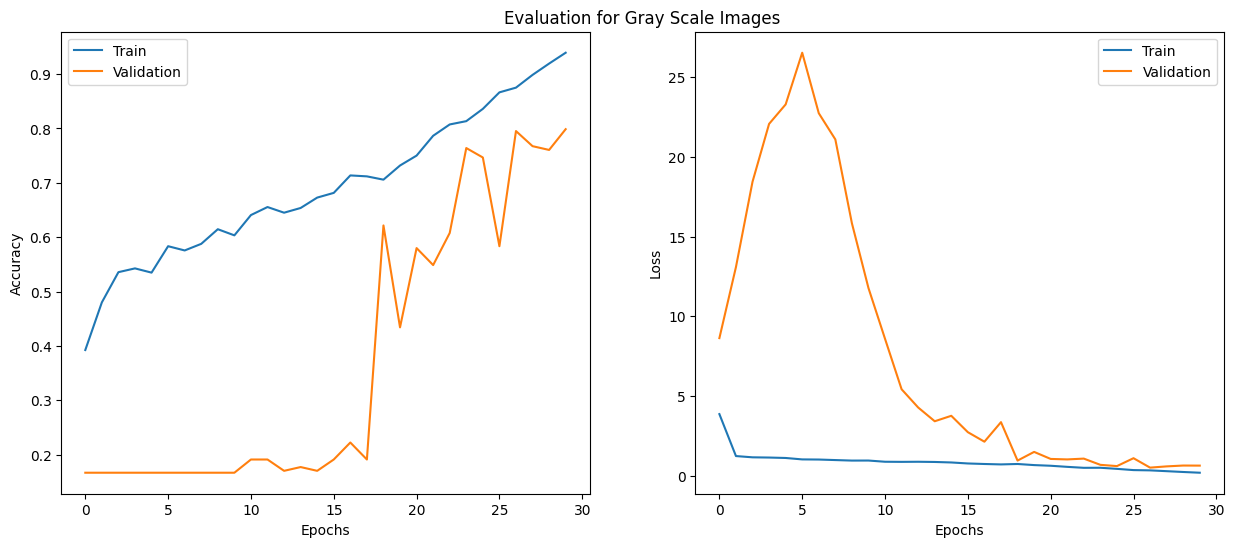

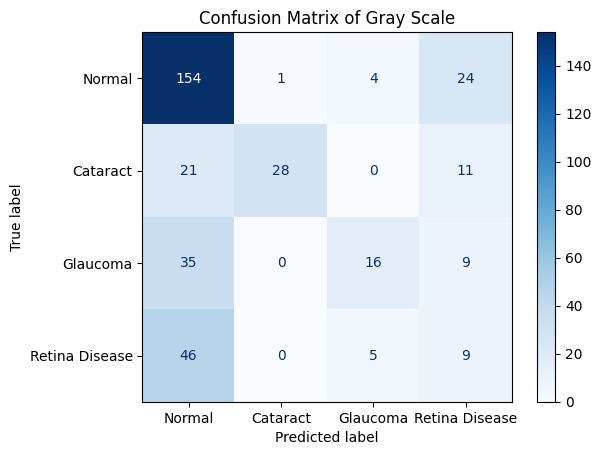

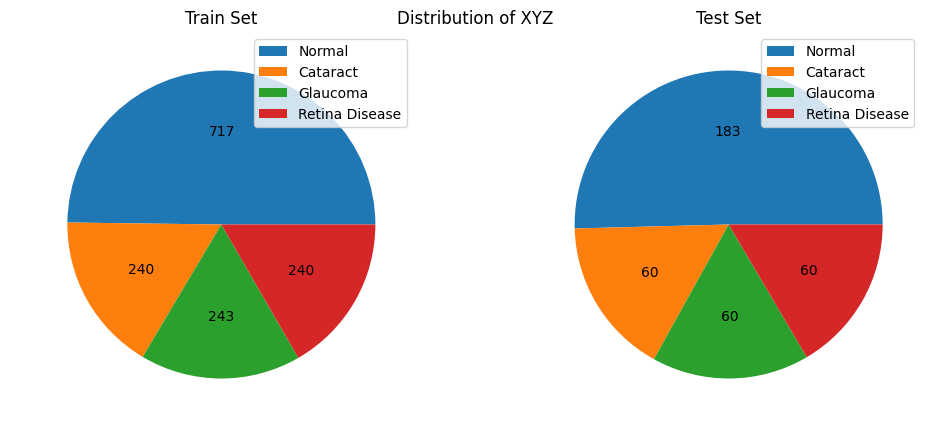

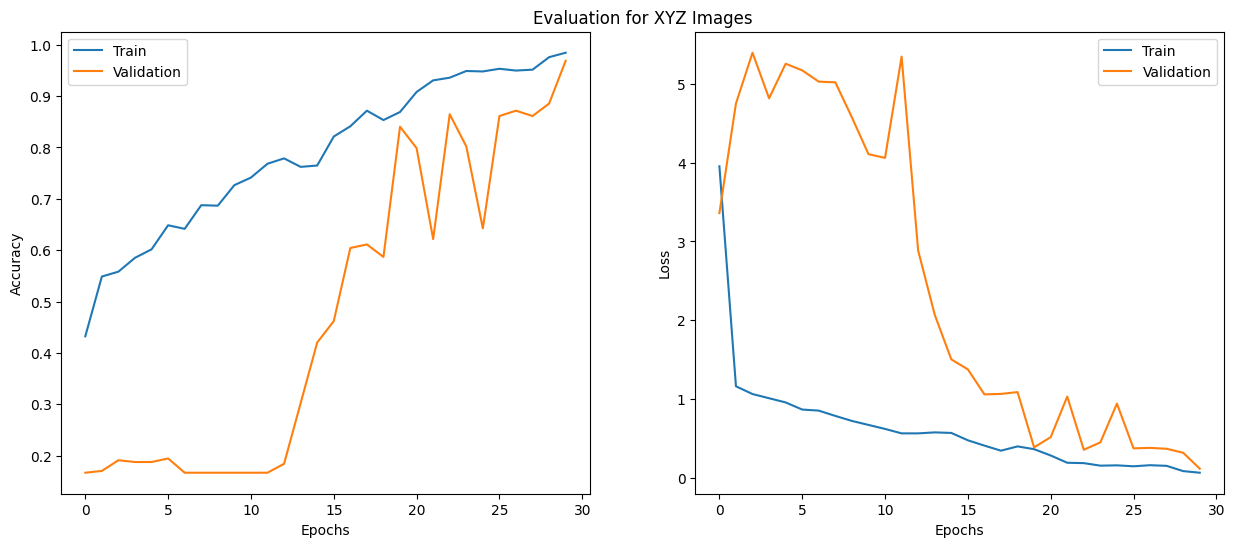

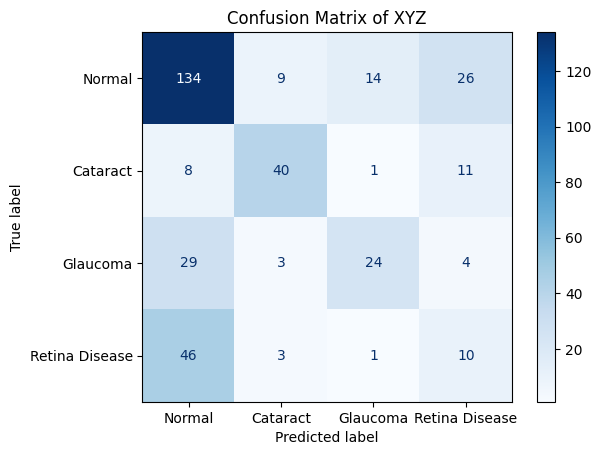

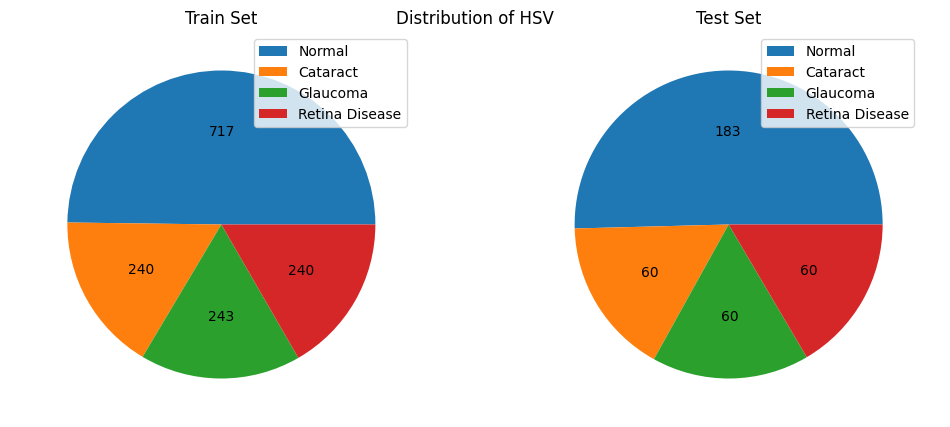

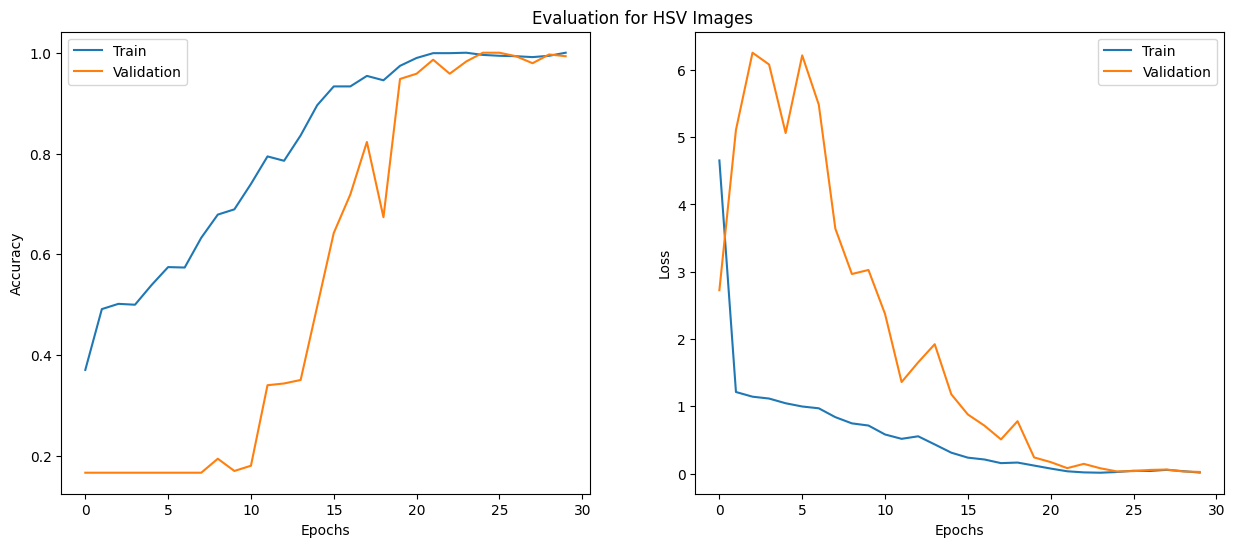

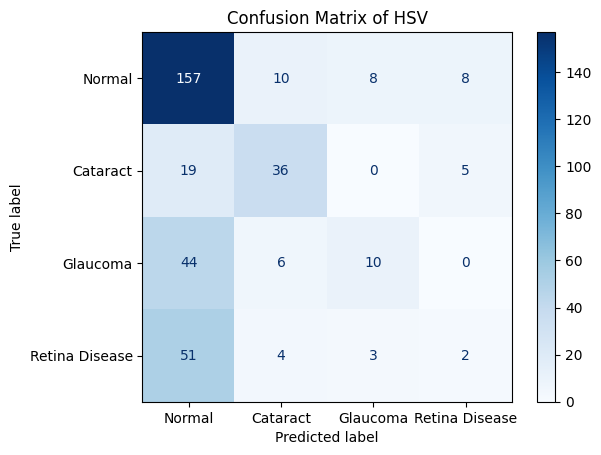

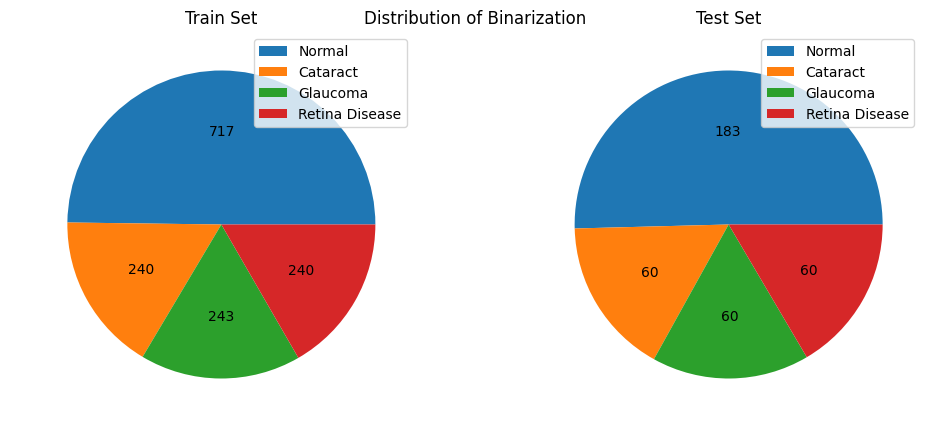

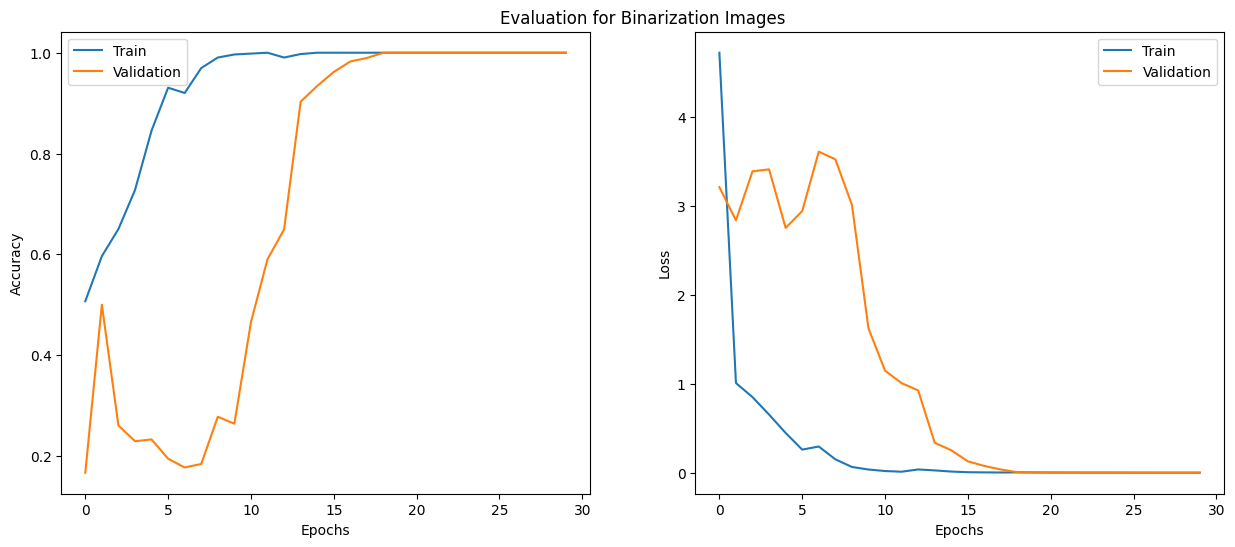

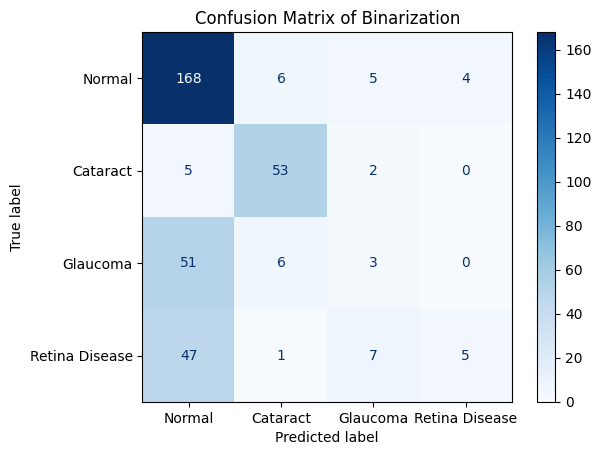

In [7]:
dict_sens={}
dict_spec={}
for i, technique in enumerate(techniques):
    X_train, y_train, X_test, y_test = read_dataset(mode=i)
    Helper.plot_pie_sets([np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)], technique)
    if technique in single_channels:
        model = create_model(channel_size=1)
    else:
        model=create_model()
    model, acc, val_acc, loss, val_loss, test_acc, test_loss = strafied_kfold(model, X_train, y_train, X_test, y_test)
    Helper.plot_history([acc, val_acc, loss, val_loss], technique)
    sensitivity,specificity = Helper.plot_conf_matrix(model, X_test, y_test, technique)
    dict_sens[technique]=sensitivity
    dict_spec[technique]=specificity

In [9]:
classes = list(dict_sens.keys())
values1 = list(dict_sens.values())
values2 = list(dict_spec.values())

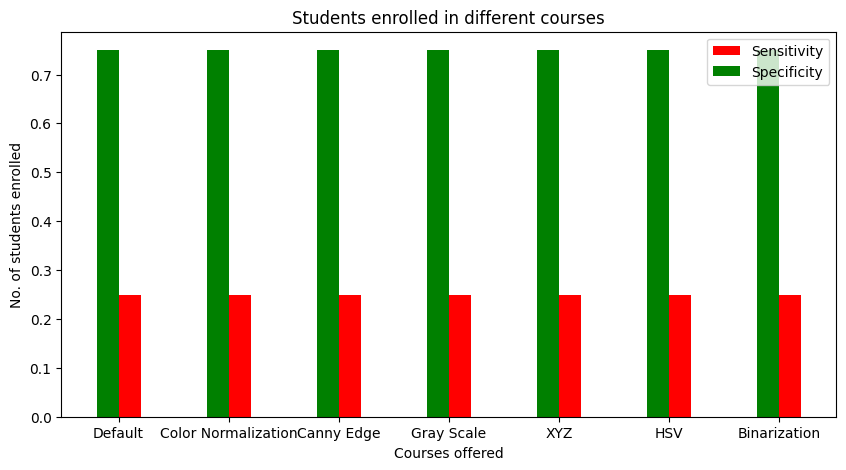

In [14]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(classes, values1, color ='red',
        width = 0.2,label="Sensitivity",align="edge")
plt.bar(classes, values2, color ='green',
        width = -0.2,label="Specificity",align="edge")

plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.legend(loc=0)
plt.show()

In [15]:
print(dict_sens)

{'Default': 0.25, 'Color Normalization': 0.25, 'Canny Edge': 0.25, 'Gray Scale': 0.25, 'XYZ': 0.25, 'HSV': 0.25, 'Binarization': 0.25}
